# Home Credit Default Risk
This project focused on applying supervised learning classification algorithms to predict loan defaults.

The dataset for this project can be found [here](https://www.kaggle.com/c/home-credit-default-risk)<br>
**Data Description/scheme:**<br>
![](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)


## Notebook navigation:
### [Exploratory analysis (feature engineering and visualization)](#Exploretary-analysis)
- **[Application table](#Application-table):**
_Information about loan and loan applicant, target value (default/no default) distribution_
- **[Bureau balance table](#Bureau-balance-table):** _client's previous credits provided by other financial institutions (features created)_
- **[Cash loan balance](#Cash-loan-balance):** _Monthly balance snapshots of previous POS (point of sales) and cash loans_
- **[Credit card balance table](#Credit-card-balance-table):** _Monthly balance snapshots of previous credit cards that the applicant has with Home Credit_
- **[Prev applications with the bank](#Prev-applications-with-the-bank):** _All previous applications for Home Credit loans of clients who have loans in these data set_
- **[Installments payments table](#Installments-payments-table):** _Repayment history for the previously disbursed credits in Home Credit_

### [Analysis, modeling](#Analysis,-modeling)
- **[Logistic regression](#Logistic-regression)**
- **[Random forest](#Random-forest)**
- **[XGBoost](#XGBoost)**
- **[Model comparison (ROC curve)](#Model-comparison-(ROC-curve))**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style='white')

import warnings

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import psycopg2 as pg
import pandas.io.sql as pd_sql
import statistics

In [2]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

In [133]:
# I store my data on AWS
## tables were created with postgre_sql

connection_args = {
    'host': '....', # IP on AWS
    'user': 'ubuntu',    
    'dbname': 'credit',   # name of database 
    'port': 5432          
}


connection = pg.connect(**connection_args)

## Exploretary analysis

#### Application table

In [4]:
query = ("SELECT SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, \
                AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, NAME_TYPE_SUITE, NAME_INCOME_TYPE, \
                NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, \
                DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, FLAG_MOBIL, \
                FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, \
                OCCUPATION_TYPE, CNT_FAM_MEMBERS, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, \
                DAYS_LAST_PHONE_CHANGE, AMT_REQ_CREDIT_BUREAU_DAY \
FROM application;")

df = pd_sql.read_sql(query, connection)

In [5]:
# After going through file with columns' descriptions and guidence from owners of the data set 
# I decided to choose only several features/columns (not all) that I think make more sense for the analysis

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 32 columns):
sk_id_curr                    307511 non-null int64
target                        307511 non-null int64
name_contract_type            307511 non-null object
flag_own_car                  307511 non-null object
flag_own_realty               307511 non-null object
cnt_children                  307511 non-null int64
amt_income_total              307511 non-null float64
amt_credit                    307511 non-null float64
amt_annuity                   307499 non-null float64
name_type_suite               306219 non-null object
name_income_type              307511 non-null object
name_education_type           307511 non-null object
name_family_status            307511 non-null object
name_housing_type             307511 non-null object
region_population_relative    307511 non-null float64
days_birth                    307511 non-null int64
days_employed                 307511 non-

In [6]:
# Target variable is whether client: 0 - didn't default on a loan or 1 - default (had payment difficulties)
target_distribution = df.target.value_counts(normalize=True)
target_distribution

0    0.919271
1    0.080729
Name: target, dtype: float64

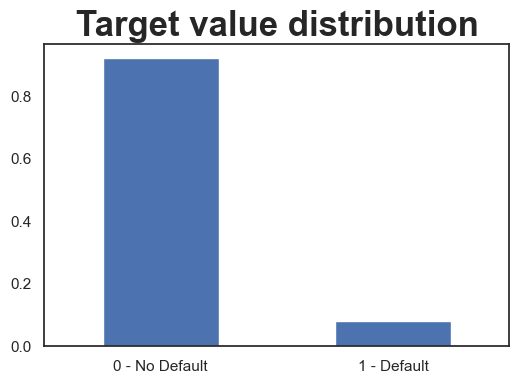

In [137]:
# Target value distribution - class imbalace, that will be handeled later in the analysis 

plt.figure(dpi=100)
target_distribution.plot(kind='bar')
plt.xticks([0,1],['0 - No Default', '1 - Default'], rotation=0)
plt.grid(b=False)
plt.title('Target value distribution', fontsize=25, fontweight='bold');

In [10]:
df.amt_income_total.sort_values()

1688          25650.0
20759         25650.0
246121        26100.0
240140        26100.0
186657        26100.0
             ...     
131140      6750000.0
77778       9000000.0
246880     13500000.0
203729     18000090.0
12880     117000000.0
Name: amt_income_total, Length: 307511, dtype: float64

In [11]:
# last few incomes seem plausble, but will exclude from the data, since it might be potential outliers
##as well as 117000000.0, which is clercal mistake (noted by data owners)
df[df.index == 246880]

,sk_id_curr,target,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,name_type_suite,...,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,days_last_phone_change,amt_req_credit_bureau_day
246880,385674,0,Cash loans,Y,Y,0,13500000.0,1400503.5,130945.5,Unaccompanied,...,1,0,0,None,2.0,NaN,0.713507,NaN,-13.0,NaN


In [12]:
df.drop([246880, 203729, 12880], axis=0, inplace=True)

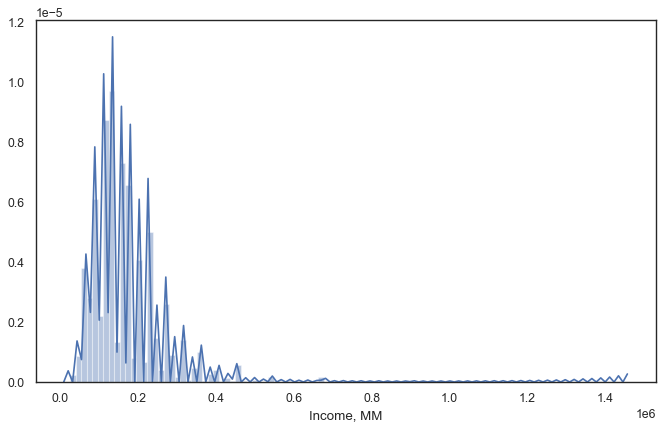

In [58]:
# Distribution of income, large values were excluded

plt.figure(figsize=(10,6),dpi=80);
sns.distplot(df[df['amt_income_total']<1500000].amt_income_total, bins=100, norm_hist=True);
plt.xlabel('Income, MM');

In [59]:
#creating feature Debt to income ratio
#as annuity (month) / income (month)
df['DTI_ratio'] = df['amt_annuity'] / df['amt_income_total']

In [60]:
df['DTI_ratio'].sort_values(ascending=False).head(10)

20759     1.875965
197696    1.570600
247636    1.451571
226157    1.393300
82        1.373917
205615    1.350750
35812     1.301500
293609    1.290231
200917    1.282667
173572    1.197667
Name: DTI_ratio, dtype: float64

In [61]:
df[df.index == 205615]

,sk_id_curr,target,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,name_type_suite,...,flag_phone,flag_email,occupation_type,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,days_last_phone_change,amt_req_credit_bureau_day,DTI_ratio
205615,338291,1,Cash loans,N,N,0,36000.0,1223010.0,48627.0,Family,...,0,0,None,2.0,NaN,0.747107,NaN,0.0,NaN,1.35075


In [62]:
# age of a client is presented in days at the time of application
## for the analysis convert it into the years, as well as check for any inconsistances/errors

df['days_birth']

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: days_birth, Length: 307508, dtype: int64

In [63]:
df['AGE_years'] = round(df['days_birth'] / (-365),1)

In [66]:
print('Average Age years: ', round(df['AGE_years'].mean(),1))
print('Median Age years', df['AGE_years'].median())
print('Age of the oldest client: ', df['AGE_years'].max())
print('Age of the youngest client: ', df['AGE_years'].min())
df['AGE_years'].sort_values()

Average Age years:  43.9
Median Age years 43.2
Age of the oldest client:  69.1
Age of the youngest client:  20.5


235448    20.5
35975     21.0
65434     21.0
186852    21.0
137194    21.0
          ... 
238188    69.0
173496    69.0
263168    69.0
282047    69.0
265052    69.1
Name: AGE_years, Length: 307508, dtype: float64

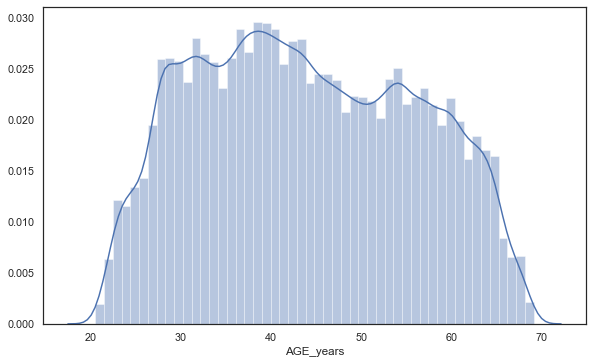

In [69]:
plt.figure(figsize=(10,6),dpi=70);
sns.distplot(df['AGE_years']);

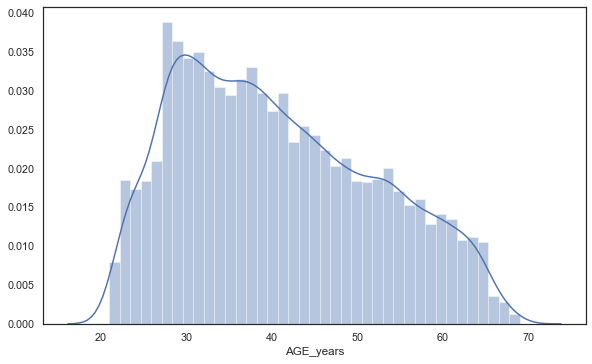

In [70]:
# distribution of age of clients, who have difficulties with payment (default)
## mostly 25 - 40 age group category of applicants 
plt.figure(figsize=(10,6),dpi=70);
sns.distplot(df[df['target'] == 1]['AGE_years']);

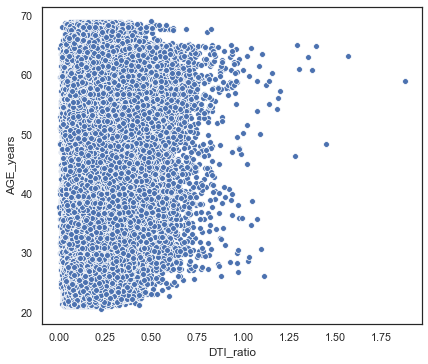

In [72]:
# Distribution of age vs. debt to income ratio
plt.figure(figsize=(7,6),dpi=70);
sns.scatterplot(x=df['DTI_ratio'], y=df['AGE_years']);

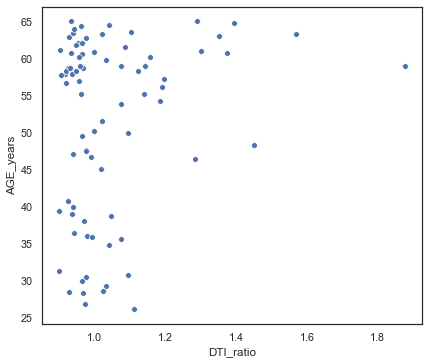

In [73]:
# Distribution of age vs. debt to income ratio with DTI more then .9
## such high DTI more common for clients that older then 50 
### (who are most likely pansioners, who also might have savings to repay loan)

plt.figure(figsize=(7,6),dpi=70);
sns.scatterplot(x=df[df['DTI_ratio'] > .9]['DTI_ratio'], y=df['AGE_years']);

In [74]:
#Now let's create another feature to see how many years aplicant was employed before applying
df['DAYS_EMPLOYED_years'] = round((df['days_employed'] / -365), 1)

In [75]:
df['DAYS_EMPLOYED_years'].sort_values()

216178   -1000.7
203883   -1000.7
183464   -1000.7
183467   -1000.7
183469   -1000.7
           ...  
234177      48.0
35216       48.0
208937      48.1
273098      48.2
281003      49.1
Name: DAYS_EMPLOYED_years, Length: 307508, dtype: float64

In [76]:
#values with -1000.7 haven't been explained. (Value 365243 denotes infinity in DAYS) - by owners of the data 
##changing for 0, however, distort value counts, so I change it for small value close to 0
df['DAYS_EMPLOYED_years'].replace({-1000.7: 0.001}, inplace=True)

In [77]:
#creating new feature with loan term
df['LOAN_TERM_years'] = (df['amt_credit'] / df['amt_annuity']) / 12

In [78]:
df['LOAN_TERM_years'].sort_values(ascending=False)

202395    3.775423
85638     3.775168
62215     3.774857
45188     3.774627
69109     3.774494
            ...   
123897         NaN
207221         NaN
227952         NaN
239299         NaN
241840         NaN
Name: LOAN_TERM_years, Length: 307508, dtype: float64

In [79]:
# data represented by short term loans
df.name_contract_type.value_counts()

Cash loans         278229
Revolving loans     29279
Name: name_contract_type, dtype: int64

In [80]:
#change car and realty for 1 - yes, 0 - no, in case of missing values to change that to 0
df['flag_own_car'].replace({'Y': 1, 'N': 0}, inplace=True)
df['flag_own_realty'].replace({'Y': 1, 'N': 0}, inplace=True)

In [81]:
df['occupation_type'].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', None,
       'Sales staff', 'Drivers', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

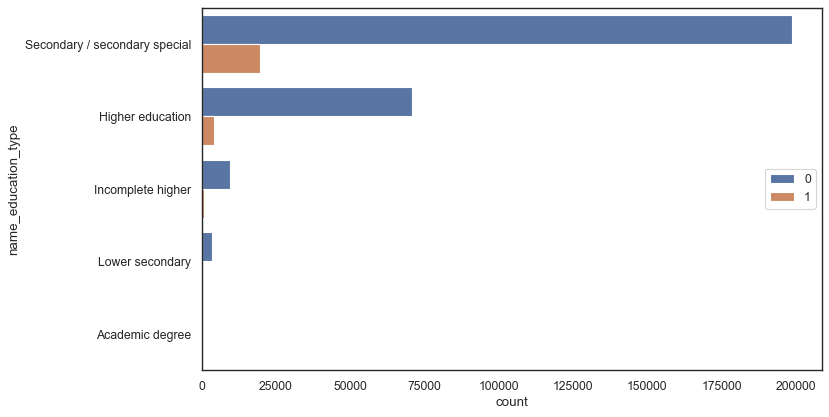

In [89]:
plt.figure(figsize=(10,6),dpi=80);
sns.countplot(y=df['name_education_type'], hue=df['target'])
plt.legend(loc='center right');

# Defaul on payments more likely among clients with Secondary / secondary special education type

In [131]:
# plotting data as % of default from each category by education type
ratios = []
for edu_type in df['name_education_type'].unique():
    num_default = df[(df['name_education_type'] == edu_type)&(df['target'] == 1)].name_education_type.count()
    num_all = df[df['name_education_type'] == edu_type].name_education_type.count()
    ratio = round((100*num_default / num_all),2)
    ratios.append((edu_type, ratio))

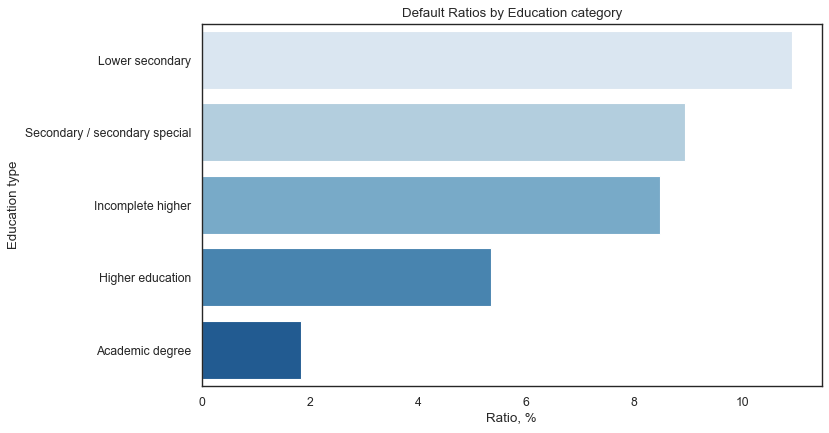

In [132]:
plt.figure(figsize=(10,6),dpi=80);
sns.barplot(y=pd.DataFrame(ratios).sort_values(1, ascending=False)[0], x=pd.DataFrame(ratios)[1], palette="Blues");
plt.ylabel('Education type');
plt.xlabel('Ratio, %');
plt.title('Default Ratios by Education category');

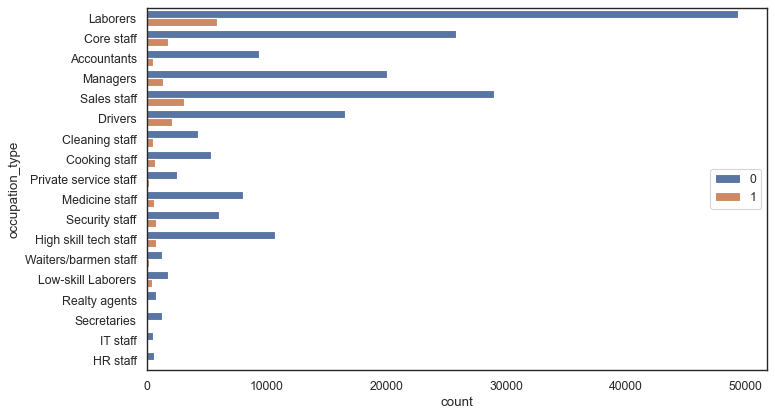

In [90]:
plt.figure(figsize=(10,6),dpi=80);
sns.countplot(y=df['occupation_type'], hue=df['target'])
plt.legend(loc='center right');

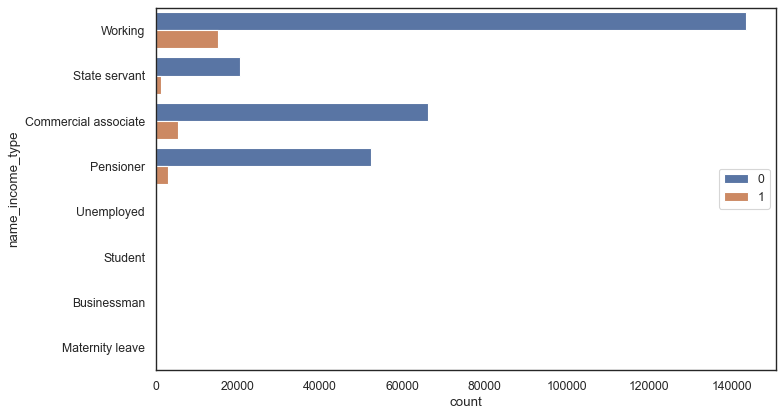

In [94]:
plt.figure(figsize=(10,6),dpi=80);
sns.countplot(y=df['name_income_type'], hue=df['target'])
plt.legend(loc='center right');

In [57]:
#Pickle
df.to_pickle("./df_application_all.pkl")

##df= pd.read_pickle("./df_application_all.pkl")

**Working with bureau data** <br>getting new features

In [134]:
# table with information of client's previous credits provided by other financial institutions

query2 = "SELECT * FROM bureau;"

df_bur = pd_sql.read_sql(query2, connection)

In [135]:
df_bur.shape

(1716428, 17)

#### Bureau balance table

In [79]:
# table with client's Monthly balances of previous credits in Credit Bureau

query3 = "SELECT * FROM bureau_balance;"

df_bureau_balance = pd_sql.read_sql(query3, connection)

In [80]:
#to identify which loan is default, to make it easier, replace X (no info) and C (closed) for 0
##I'm more interested in loans that have Days of Past Due
df_bureau_balance.status.replace({'C': '0', 'X': '0'}, inplace=True)

In [81]:
# 0: no DPD, 
# 1: max during month between 1-30 days,
# 2: DPD 31-60 days, 
# …
# 5: DPD 120+ days or sold or written off

df_bureau_balance.status.unique()

array(['0', '1', '2', '3', '5', '4'], dtype=object)

In [82]:
df_bureau_balance.head(1)

,sk_bureau_id,months_balance,status
0,5715448,0,0


In [84]:
# finding what was the max status of DPD for each client

df_bureau_balance = df_bureau_balance.groupby('sk_bureau_id').agg({'status': 'max'}).reset_index()

In [85]:
df_bureau_balance.status.value_counts()

0    714131
1     87055
2      7841
5      5214
3      2077
4      1077
Name: status, dtype: int64

In [86]:
df_bureau_balance.shape

(817395, 2)

In [93]:
df_bur.shape

(1716428, 17)

In [94]:
##merge with bureau table
df_bureau_merged = pd.merge(df_bur, df_bureau_balance, how='left', on=['sk_bureau_id'])

In [95]:
df_bureau_merged.shape

(1716428, 18)

In [96]:
df_bureau_merged.head(3)

,sk_id_curr,sk_bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity,status
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN


In [97]:
#changing all NaN values in status column for loans that most likely didn't have any info previously
df_bureau_merged.status.fillna('0', inplace=True)

In [98]:
df_bureau_all = df_bureau_merged.groupby(['sk_id_curr']).agg({'sk_bureau_id': 'count',
                                                                'days_credit': 'mean',
                                                                'days_credit_enddate': 'mean',
                                                                'credit_day_overdue': 'mean',
                                                                'cnt_credit_prolong': 'mean',
                                                                'amt_credit_max_overdue': 'mean',
                                                                'amt_credit_sum': 'mean',
                                                                'credit_type': lambda x:x.value_counts().index[0],
                                                                'status': 'max'})

In [99]:
df_bureau_all.head(3)

,sk_bureau_id,days_credit,days_credit_enddate,credit_day_overdue,cnt_credit_prolong,amt_credit_max_overdue,amt_credit_sum,credit_type,status
sk_id_curr,,,,,,,,,
100001,7,-735.00,82.428571,0.0,0.0,NaN,207623.571429,Consumer credit,1
100002,8,-874.00,-349.000000,0.0,0.0,1681.029,108131.945625,Consumer credit,1
100003,4,-1400.75,-544.500000,0.0,0.0,0.000,254350.125000,Consumer credit,0


In [100]:
# creating column with average term of loans, years
df_bureau_all['avr_term_loan'] = (abs(df_bureau_all.days_credit) + abs(df_bureau_all.days_credit_enddate))/365

In [101]:
# drop redundant columns
df_bureau_all.drop(['days_credit', 'days_credit_enddate'], axis=1, inplace=True)

In [103]:
df_bureau_all = df_bureau_all.reset_index()

In [105]:
df_bureau_all.head(3)

,sk_id_curr,sk_bureau_id,credit_day_overdue,cnt_credit_prolong,amt_credit_max_overdue,amt_credit_sum,credit_type,status,avr_term_loan
0,100001,7,0.0,0.0,NaN,207623.571429,Consumer credit,1,2.239530
1,100002,8,0.0,0.0,1681.029,108131.945625,Consumer credit,1,3.350685
2,100003,4,0.0,0.0,0.000,254350.125000,Consumer credit,0,5.329452


In [106]:
#renaming columns for later merge
df_bureau_all.columns

Index(['sk_id_curr', 'sk_bureau_id', 'credit_day_overdue',
       'cnt_credit_prolong', 'amt_credit_max_overdue', 'amt_credit_sum',
       'credit_type', 'status', 'avr_term_loan'],
      dtype='object')

In [107]:
new_column_name = (['sk_id_curr', 'sk_bureau_id', 'bureau_avg_days_overdue',
       'bureau_avg_cnt_prolong', 'bureau_avg_amt_max_overdue', 'bureau_avg_amt_credit',
       'bureau_credit_type', 'bureau_max_pastdue_30_120', 'bureau_avr_term_loan'])

In [108]:
df_bureau_all.columns = new_column_name

In [110]:
df_bureau_all.head(3)

,sk_id_curr,sk_bureau_id,bureau_avg_days_overdue,bureau_avg_cnt_prolong,bureau_avg_amt_max_overdue,bureau_avg_amt_credit,bureau_credit_type,bureau_max_pastdue_30_120,bureau_avr_term_loan
0,100001,7,0.0,0.0,NaN,207623.571429,Consumer credit,1,2.239530
1,100002,8,0.0,0.0,1681.029,108131.945625,Consumer credit,1,3.350685
2,100003,4,0.0,0.0,0.000,254350.125000,Consumer credit,0,5.329452


In [111]:
#Pickle
df_bureau_all.to_pickle("./df_bureau_all.pkl")

##df_bureau_all= pd.read_pickle("./df_bureau_all.pkl")

#### Cash loan balance

In [113]:
# table with client's Monthly balance snapshots of previous POS (point of sales) and cash loans with Home Credit Bank

query4 = "SELECT * FROM pos_cash;"

df_pos_cash = pd_sql.read_sql(query4, connection)

In [114]:
df_pos_cash.head(3)

,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0


In [115]:
df_pos_cash = df_pos_cash.groupby(['sk_id_prev', 'sk_id_curr']).agg({'name_contract_status': 'max',
                                                        'sk_dpd': 'mean'}).reset_index() # avr DPD during the month of previous credit

In [116]:
df_pos = df_pos_cash.groupby(['sk_id_curr']).agg({'sk_id_prev': 'count', # finding number of previous loan contracts
                                                        'sk_dpd': 'max'}).reset_index()

In [125]:
df_pos.columns

Index(['sk_id_curr', 'sk_id_prev', 'sk_dpd'], dtype='object')

In [128]:
df_pos.columns = ['sk_id_curr', 'pos_cnt_prev', 'pos_avg_dpd']

In [130]:
#Pickle
df_pos.to_pickle("./df_pos_all.pkl")

##df_pos= pd.read_pickle("./df_pos_all.pkl")

#### Credit card balance table

In [133]:
# Monthly balance snapshots of previous credit cards that the applicant had with Home Credit

query5 = "SELECT SK_ID_PREV, SK_ID_CURR, AMT_BALANCE, \
           AMT_CREDIT_LIMIT_ACTUAL, SK_DPD \
FROM credit_card_balance;"

df_cc_balance = pd_sql.read_sql(query5, connection)

In [134]:
df_cc_balance.head(3)

,sk_id_prev,sk_id_curr,amt_balance,amt_credit_limit_actual,sk_dpd
0,2562384,378907,56.970,135000.0,0
1,2582071,363914,63975.555,45000.0,0
2,1740877,371185,31815.225,450000.0,0


In [135]:
df_cc = df_cc_balance.groupby(['sk_id_prev', 'sk_id_curr']).agg({'amt_balance': 'mean',
                                                                         'amt_credit_limit_actual': 'mean',
                                                                         'sk_dpd': 'mean'}).reset_index()

In [136]:
df_cc.shape

(104307, 5)

In [137]:
#creating new feature of average cc balance by client
df_cc['avr_balance'] = df_cc.amt_balance / df_cc.amt_credit_limit_actual

In [138]:
##re-did in case if a client has more then a few cc 
df_cc = df_cc.groupby(['sk_id_curr']).agg({'sk_id_prev': 'count',
                                                                 'amt_balance': 'mean',
                                                                 'amt_credit_limit_actual': 'mean',
                                                                 'sk_dpd': 'mean',
                                                                 'avr_balance': 'mean'}).reset_index()

In [141]:
df_cc.sk_id_prev.sort_values()

0         1
68939     1
68938     1
68937     1
68936     1
         ..
89626     3
96387     3
30848     3
100347    3
74145     4
Name: sk_id_prev, Length: 103558, dtype: int64

In [143]:
df_cc.columns = ['sk_id_curr', 'cc_cnt_prev', 'cc_avg_amt', 'cc_avg_amt',
       'cc_avg_dpd', 'cc_avr_balance']

In [144]:
#Pickle
df_cc.to_pickle("./df_cc_prev_all.pkl")

##df_cc_prev= pd.read_pickle("./df_cc_prev_all.pkl")

#### Prev applications with the bank

In [154]:
# Table with all previous applications for Home Credit loans of clients who have loans in these data set

query6 = "SELECT SK_ID_PREV, SK_ID_CURR, NAME_CONTRACT_TYPE, \
           AMT_CREDIT, NAME_CONTRACT_STATUS, NAME_CLIENT_TYPE \
FROM previous_application;"

df_previous_application = pd_sql.read_sql(query6, connection)

In [160]:
df_previous_application.name_contract_status.unique()

array(['Approved', 'Refused', 'Canceled', 'Unused offer'], dtype=object)

In [162]:
## I'm denoting 'Refused' as 1 and any else as 0 --> sum of 1 will show how 
# many applications were refused in providing loans
## Also, for creating a feature as % of all applications from the client
df_previous_application.name_contract_status.replace({'Approved':0,
                                                          'Canceled':0,
                                                          'Unused offer':0,
                                                          'Refused': 1}, inplace=True)

In [163]:
# XNA - missing value

df_previous_application = df_previous_application[df_previous_application.name_contract_type !='XNA']

In [164]:
df_previous_application.shape

(1669868, 37)

In [165]:
df_previous_application = df_previous_application.groupby(['sk_id_curr', 'name_contract_type']).agg({'sk_id_prev': 'count',
                                                                                    'amt_credit': 'mean',
                                                                                    'name_contract_status': 'sum'}).reset_index()
                                                                                    # sum, since changed to 1 - Refused, 0 - all other

In [166]:
df_previous_application.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,SK_ID_PREV,AMT_CREDIT,NAME_CONTRACT_STATUS
0,100001,Consumer loans,1,23787.0,0
1,100002,Consumer loans,1,179055.0,0
2,100003,Cash loans,1,1035882.0,0


In [167]:
##Creating feature for % of rejections on prev applications

df_previous_application['num_rejections'] = df_previous_application['name_contract_status']/df_previous_application['sk_id_prev']

In [171]:
df_previous_application.columns = (['sk_id_curr', 'prev_app_credit_type', 'prev_app_cnt', 
                                    'prev_app_avg_amt', 'prev_app_cnt_cnt_reject', 'prev_app_reject_ratio'])

In [172]:
df_previous_application.head(2)

,sk_id_curr,prev_app_credit_type,prev_app_cnt,prev_app_avg_amt,prev_app_cnt_cnt_reject,prev_app_reject_ratio
0,100001,Consumer loans,1,23787.0,0,0.0
1,100002,Consumer loans,1,179055.0,0,0.0


In [176]:
df_previous_application.shape

(637586, 6)

In [174]:
df_previous_application_ = df_previous_application.groupby(['sk_id_curr']).agg({'prev_app_cnt': 'mean',
                                                                             'prev_app_avg_amt': 'mean',
                                                                             'prev_app_cnt_cnt_reject': 'mean',
                                                                             'prev_app_reject_ratio': 'mean'}).reset_index()

In [175]:
df_previous_application_.shape

(338857, 5)

In [177]:
#Pickle
df_previous_application_.to_pickle("./df_previous_application_.pkl")

##df_previous_application_= pd.read_pickle("./df_previous_application_.pkl")

#### Installments payments table

In [178]:
# Table with client's information on Repayment history for the previously disbursed credits in Home Credit

query7 = "SELECT * FROM installments_payments;"

df_installments_payments = pd_sql.read_sql(query7, connection)

In [179]:
df_installments_payments.head()

,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [180]:
#create featute DPD
df_installments_payments['DPD_loan'] = abs(df_installments_payments.days_entry_payment - df_installments_payments.days_instalment)

In [182]:
#correct values when days of actual payment is lower then should be (possible inconsistencies in a data set)
df_installments_payments['DPD_loan'][df_installments_payments['days_instalment'] <  df_installments_payments['days_entry_payment']] = 0

/Users/Daria/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [183]:
df_installments_payments['DPD_loan'][df_installments_payments['days_instalment'] <  df_installments_payments['days_entry_payment']]

4           0.0
19          0.0
30          0.0
45          0.0
47          0.0
           ... 
13605308    0.0
13605319    0.0
13605328    0.0
13605340    0.0
13605348    0.0
Name: DPD_loan, Length: 1146669, dtype: float64

In [184]:
df_installments_payments_ = df_installments_payments.groupby(['sk_id_curr', 'sk_id_prev']).agg({
                                                                 'amt_instalment': 'mean',
                                                                 'DPD_loan': 'mean'}).reset_index()

In [185]:
df_installments_payments_ = df_installments_payments_.groupby(['sk_id_curr']).agg({'sk_id_prev': 'count',
                                                                     'amt_instalment': 'mean',
                                                                     'DPD_loan': 'mean'}).reset_index()

In [187]:
df_installments_payments_.columns = ['sk_id_curr', 'loan_cnt_loan', 'loan_avr_instalment', 'loan_dpd']

In [188]:
#Pickle
df_installments_payments_.to_pickle("./df_installments_payments.pkl")

##df_installments_payments= pd.read_pickle("./df_installments_payments.pkl")

**MERGE ALL**

In [189]:
df_bureau_all.head(2)

,sk_id_curr,sk_bureau_id,bureau_avg_days_overdue,bureau_avg_cnt_prolong,bureau_avg_amt_max_overdue,bureau_avg_amt_credit,bureau_credit_type,bureau_max_pastdue_30_120,bureau_avr_term_loan
0,100001,7,0.0,0.0,NaN,207623.571429,Consumer credit,1,2.239530
1,100002,8,0.0,0.0,1681.029,108131.945625,Consumer credit,1,3.350685


In [190]:
df_bureau_all.shape

(305811, 9)

In [191]:
df.shape

(307508, 36)

In [192]:
df_merged = pd.merge(df, df_bureau_all, how='left', on=['sk_id_curr'])

In [193]:
df_merged.shape

(307508, 44)

In [194]:
df_pos.shape

(337252, 3)

In [195]:
df_merged2 = pd.merge(df_merged, df_pos, how='left', on=['sk_id_curr'])

In [196]:
df_merged2.shape

(307508, 46)

In [197]:
df_cc.shape

(103558, 6)

In [198]:
df_merged3 = pd.merge(df_merged2, df_cc, how='left', on=['sk_id_curr'])

In [199]:
df_previous_application_.shape

(338857, 5)

In [200]:
df_previous_application_.columns

Index(['sk_id_curr', 'prev_app_cnt', 'prev_app_avg_amt',
       'prev_app_cnt_cnt_reject', 'prev_app_reject_ratio'],
      dtype='object')

In [201]:
df_merged4 = pd.merge(df_merged3, df_previous_application_, how='left', on=['sk_id_curr'])

In [202]:
df_installments_payments_.shape

(339587, 4)

In [203]:
df_merged5 = pd.merge(df_merged4, df_installments_payments_, how='left', on=['sk_id_curr'])

In [204]:
df_merged5.shape

(307508, 58)

In [205]:
df_merged5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307508 entries, 0 to 307507
Data columns (total 58 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   sk_id_curr                  307508 non-null  int64  
 1   target                      307508 non-null  int64  
 2   name_contract_type          307508 non-null  object 
 3   flag_own_car                307508 non-null  int64  
 4   flag_own_realty             307508 non-null  int64  
 5   cnt_children                307508 non-null  int64  
 6   amt_income_total            307508 non-null  float64
 7   amt_credit                  307508 non-null  float64
 8   amt_annuity                 307496 non-null  float64
 9   name_type_suite             306216 non-null  object 
 10  name_income_type            307508 non-null  object 
 11  name_education_type         307508 non-null  object 
 12  name_family_status          307508 non-null  object 
 13  name_housing_t

In [206]:
#Pickle
df_merged5.to_pickle("./df_merged5.pkl")

##df_merged_all= pd.read_pickle("./df_merged5.pkl")

**Another look at merged data**

In [207]:
# Another look at data set for potential cleaning before analysis 

In [384]:
df_merged_all= pd.read_pickle("./df_merged5.pkl")

In [385]:
df_merged_all.columns

Index(['sk_id_curr', 'target', 'name_contract_type', 'flag_own_car',
       'flag_own_realty', 'cnt_children', 'amt_income_total', 'amt_credit',
       'amt_annuity', 'name_type_suite', 'name_income_type',
       'name_education_type', 'name_family_status', 'name_housing_type',
       'region_population_relative', 'days_birth', 'days_employed',
       'days_registration', 'days_id_publish', 'flag_mobil', 'flag_emp_phone',
       'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email',
       'occupation_type', 'cnt_fam_members', 'ext_source_1', 'ext_source_2',
       'ext_source_3', 'days_last_phone_change', 'amt_req_credit_bureau_day',
       'DTI_ratio', 'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years',
       'sk_bureau_id', 'bureau_avg_days_overdue', 'bureau_avg_cnt_prolong',
       'bureau_avg_amt_max_overdue', 'bureau_avg_amt_credit',
       'bureau_credit_type', 'bureau_max_pastdue_30_120',
       'bureau_avr_term_loan', 'pos_cnt_prev', 'pos_avg_dpd', 'cc_cnt_prev

In [386]:
df_merged_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307508 entries, 0 to 307507
Data columns (total 58 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   sk_id_curr                  307508 non-null  int64  
 1   target                      307508 non-null  int64  
 2   name_contract_type          307508 non-null  object 
 3   flag_own_car                307508 non-null  int64  
 4   flag_own_realty             307508 non-null  int64  
 5   cnt_children                307508 non-null  int64  
 6   amt_income_total            307508 non-null  float64
 7   amt_credit                  307508 non-null  float64
 8   amt_annuity                 307496 non-null  float64
 9   name_type_suite             306216 non-null  object 
 10  name_income_type            307508 non-null  object 
 11  name_education_type         307508 non-null  object 
 12  name_family_status          307508 non-null  object 
 13  name_housing_t

In [387]:
# drop, since I'm using DTI ratio
df_merged_all.dropna(subset=['amt_annuity'], inplace=True)

In [389]:
# filling missing values with 'Other'
df_merged_all['name_type_suite'].fillna(value='Other', inplace=True)

In [390]:
df_merged_all['occupation_type'].fillna(value='Other', inplace=True)

In [392]:
# From sample data (analysis that was done before by me on a smaller data set), 
# I remember that some features weren't important at all --> dropping them

df_merged_all.drop(['cc_avg_amt', 'cc_avg_amt', 'cc_avr_balance', 'cc_avg_dpd'], axis=1, inplace=True)

In [428]:
df_merged_all.describe()

,sk_id_curr,target,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,region_population_relative,days_birth,...,pos_cnt_prev,pos_avg_dpd,cc_cnt_prev,prev_app_cnt,prev_app_avg_amt,prev_app_cnt_cnt_reject,prev_app_reject_ratio,loan_cnt_loan,loan_avr_instalment,loan_dpd
count,307496.000000,307496.00000,307496.000000,307496.000000,307496.000000,3.074960e+05,3.074960e+05,307496.000000,307496.000000,307496.000000,...,289429.000000,289429.000000,86896.000000,291042.000000,2.910420e+05,291042.000000,291042.000000,291628.000000,2.916280e+05,291620.000000
mean,278181.927576,0.08073,0.340108,0.693687,0.417062,1.683159e+05,5.990246e+05,27108.102001,0.020868,-16037.074508,...,2.765079,1.575370,1.006295,2.488262,1.670741e+05,0.390067,0.101485,2.925971,2.271693e+04,12.909996
std,102790.209032,0.27242,0.473746,0.460962,0.722127,1.011350e+05,4.024920e+05,14492.398549,0.013831,4364.015005,...,1.963068,10.631052,0.079959,1.743710,1.600900e+05,0.822084,0.176450,2.041033,3.609747e+04,8.646809
min,100002.000000,0.00000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,-25229.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000e+00,0.000000
25%,189149.750000,0.00000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,-19682.000000,...,1.000000,0.000000,1.000000,1.000000,6.594708e+04,0.000000,0.000000,1.000000,8.293507e+03,7.516667
50%,278203.500000,0.00000,0.000000,1.000000,0.000000,1.468125e+05,5.135310e+05,24903.000000,0.018850,-15750.000000,...,2.000000,0.000000,1.000000,2.000000,1.177299e+05,0.000000,0.000000,2.000000,1.339755e+04,11.000000
75%,367143.250000,0.00000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,0.028663,-12413.000000,...,4.000000,0.000000,1.000000,3.000000,2.139268e+05,0.500000,0.166667,4.000000,2.382326e+04,15.935951
max,456255.000000,1.00000,1.000000,1.000000,19.000000,9.000000e+06,4.050000e+06,258025.500000,0.072508,-7489.000000,...,26.000000,100.000000,4.000000,36.000000,4.050000e+06,29.000000,1.000000,26.000000,2.504590e+06,120.000000


In [1143]:
len(df_merged_all.columns)

54

In [394]:
#set extreme values to 100
df_merged_all['pos_avg_dpd'][df_merged_all.pos_avg_dpd > 100] = 100

/Users/Daria/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [407]:
df_merged_all['prev_app_cnt_cnt_reject'][df_merged_all['prev_app_cnt_cnt_reject'] > 1]

26        10.000000
31         4.000000
37         1.666667
53         2.666667
56         1.333333
            ...    
307436     1.500000
307476     1.666667
307480     1.500000
307484     1.333333
307496     2.000000
Name: prev_app_cnt_cnt_reject, Length: 27927, dtype: float64

In [426]:
# such big values don't make any sense --> change them to 120 days that usually means selling a loan
df_merged_all['loan_dpd'][df_merged_all.loan_dpd > 120] = 120

/Users/Daria/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [436]:
# such big values don't make any sense --> change them to 120 days that usually means selling a loan
df_merged_all['bureau_avg_days_overdue'][df_merged_all.bureau_avg_days_overdue > 120] = 120

/Users/Daria/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [430]:
df_merged_all.bureau_max_pastdue_30_120.fillna('0', inplace=True)

In [433]:
df_merged_all.columns

Index(['sk_id_curr', 'target', 'name_contract_type', 'flag_own_car',
       'flag_own_realty', 'cnt_children', 'amt_income_total', 'amt_credit',
       'amt_annuity', 'name_type_suite', 'name_income_type',
       'name_education_type', 'name_family_status', 'name_housing_type',
       'region_population_relative', 'days_birth', 'days_employed',
       'days_registration', 'days_id_publish', 'flag_mobil', 'flag_emp_phone',
       'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email',
       'occupation_type', 'cnt_fam_members', 'ext_source_1', 'ext_source_2',
       'ext_source_3', 'days_last_phone_change', 'amt_req_credit_bureau_day',
       'DTI_ratio', 'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years',
       'sk_bureau_id', 'bureau_avg_days_overdue', 'bureau_avg_cnt_prolong',
       'bureau_avg_amt_max_overdue', 'bureau_avg_amt_credit',
       'bureau_credit_type', 'bureau_max_pastdue_30_120',
       'bureau_avr_term_loan', 'pos_cnt_prev', 'pos_avg_dpd', 'cc_cnt_prev

In [669]:
#Pickle
df_merged_all.to_pickle("./df_merged_all_WORK.pkl")

##df_merged_all= pd.read_pickle("./df_merged_all_WORK.pkl")

In [825]:
df_merged_all.to_csv('data.csv', header=True)

**Checking feature importance for all data set, before selecting features**

In [149]:
df_merged_all= pd.read_pickle("./df_merged_all_WORK.pkl")

In [150]:
X = df_merged_all[['name_contract_type', 'flag_own_car',
       'flag_own_realty', 'cnt_children', 'amt_income_total', 'amt_credit',
       'amt_annuity', 'name_type_suite', 'name_income_type',
       'name_education_type', 'name_family_status', 'name_housing_type',
       'region_population_relative', 
       'days_registration', 'days_id_publish', 'flag_mobil', 'flag_emp_phone',
       'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email',
       'occupation_type', 'cnt_fam_members', 'ext_source_1', 'ext_source_2',
       'ext_source_3', 'days_last_phone_change', 'amt_req_credit_bureau_day',
       'DTI_ratio', 'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years',
       'bureau_avg_days_overdue', 'bureau_avg_cnt_prolong',
       'bureau_avg_amt_max_overdue', 'bureau_avg_amt_credit',
       'bureau_credit_type', 'bureau_max_pastdue_30_120',
       'bureau_avr_term_loan', 'pos_cnt_prev', 'pos_avg_dpd', 'cc_cnt_prev',
       'prev_app_cnt', 'prev_app_avg_amt', 'prev_app_cnt_cnt_reject',
       'prev_app_reject_ratio', 'loan_cnt_loan', 'loan_avr_instalment',
       'loan_dpd']]

y = df_merged_all['target']

In [153]:
# fill missing values with extreme value -9999
X.fillna(-9999, inplace=True)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X), y, \
                                                            test_size=0.3, random_state=42)

In [156]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=10)

In [157]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [158]:
importances = rf.feature_importances_

In [159]:
feature_list = list(X.columns)

In [160]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [161]:
len(feature_importances)

49

In [162]:
d = {}
for feature in feature_importances:
    d[feature[0]] = feature[1]

In [163]:
df = pd.DataFrame(d, index=[0]).T

In [164]:
df.columns = ['Importance']

In [181]:
df = df[df['Importance']>0.01].reset_index()

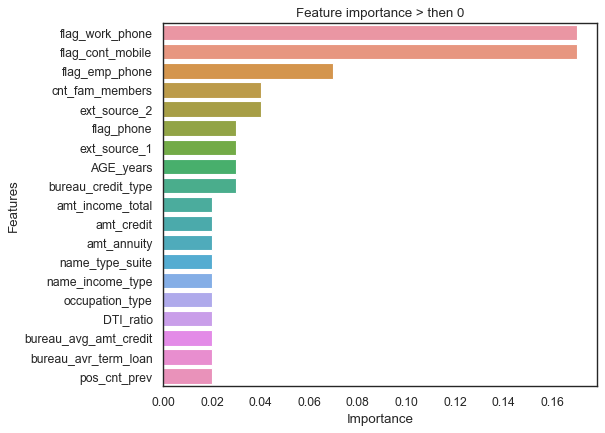

In [189]:
plt.figure(figsize=(7,6),dpi=80);
sns.barplot(x=df[df['Importance']>0]['Importance'], y=df['index']);
plt.ylabel('Features');
plt.xlabel('Importance');
plt.title('Feature importance > then 0');

In [824]:
# Print out features and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: flag_work_phone      Importance: 0.18
Variable: flag_cont_mobile     Importance: 0.16
Variable: flag_emp_phone       Importance: 0.06
Variable: cnt_fam_members      Importance: 0.04
Variable: ext_source_2         Importance: 0.04
Variable: flag_phone           Importance: 0.03
Variable: ext_source_1         Importance: 0.03
Variable: bureau_credit_type   Importance: 0.03
Variable: amt_income_total     Importance: 0.02
Variable: amt_credit           Importance: 0.02
Variable: amt_annuity          Importance: 0.02
Variable: name_type_suite      Importance: 0.02
Variable: name_income_type     Importance: 0.02
Variable: occupation_type      Importance: 0.02
Variable: DTI_ratio            Importance: 0.02
Variable: AGE_years            Importance: 0.02
Variable: bureau_avg_amt_credit Importance: 0.02
Variable: bureau_avr_term_loan Importance: 0.02
Variable: pos_cnt_prev         Importance: 0.02
Variable: cnt_children         Importance: 0.01
Variable: name_family_status   Importan

# Analysis, modeling

### Logistic regression

In [ ]:
# start modeling with logistic regression and a few selected features

In [464]:
def metrics_logit(X,y):
    
    '''
    - takes set of features X and target values y as an input for training the model,
    - splits them into training and test sets,
    - handles class imbalance for target values,
    - finds an optimal probability threshold that maximizes F1 score,
    - finds and prints AUC score,
    - shows ROC curve
    
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X), y, \
                                                            test_size=0.3, random_state=42)
    #solve for imbalanced data
    lr = LogisticRegression(class_weight='balanced', solver='liblinear') 
    lr.fit(X_train, y_train)
    
    y_pred_prob = lr.predict_proba(X_test)[:,1]
    thresh_p = np.linspace(0,1,1000)
    
    f1_scores = []
    for p in thresh_p:
        model_val_labels = y_pred_prob >= p
        f1_scores.append(f1_score(y_test, model_val_labels))
    
    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_p[np.argmax(f1_scores)]
    
    AUC_score = roc_auc_score(y_test, y_pred_prob)

    print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))
    print('Logistic Regression Model AUC score %.3f' 
          % (AUC_score))
    
    plt.plot(thresh_p, f1_scores);
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    return

In [460]:
# make a model for the first few features (base model)

X1 = df_merged_all[['name_education_type', 'DTI_ratio', 'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years']]

y1 = df_merged_all['target']

Logistic Regression Model best F1 score 0.197 at prob decision threshold >= 0.562
Logistic Regression Model AUC score 0.623


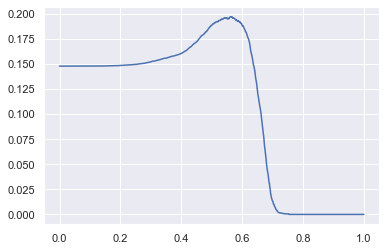

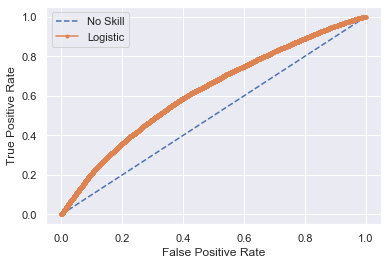

In [465]:
metrics_logit(X1, y1)

Just to compare - applying another imbalance techique

In [466]:
import imblearn.over_sampling

In [474]:
smote = imblearn.over_sampling.SMOTE(random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_sample(X_train, y_train)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_smote.predict(X_test)), roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:,1])))

Logistic Regression on SMOTE Train Data; Test F1: 0.172, Test AUC: 0.585


Results are better using **_class_weight='balanced'_**<br>
Continue working with **_'balanced'_** parameter

In [496]:
# Adding more features

X2 = df_merged_all[['name_education_type', 'days_id_publish', 
       'DTI_ratio', 'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years',
       'bureau_avg_days_overdue', 'bureau_avg_cnt_prolong',
       'bureau_max_pastdue_30_120']]

y2 = df_merged_all['target']

In [497]:
X2.fillna(0, inplace=True)

/Users/Daria/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Logistic Regression Model best F1 score 0.198 at prob decision threshold >= 0.552
Logistic Regression Model AUC score 0.630


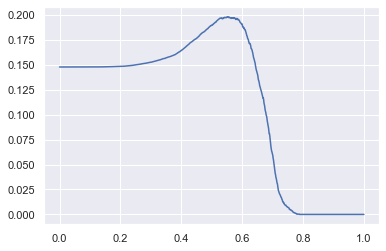

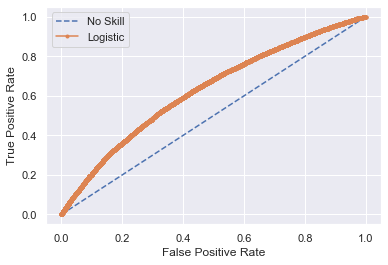

In [498]:
# got slightly bettet results

metrics_logit(X2, y2)

Trying all features that I have

In [499]:
X3 = df_merged_all[['name_contract_type', 'flag_own_car',
       'flag_own_realty', 'cnt_children', 'amt_income_total', 'amt_credit',
       'amt_annuity', 'name_type_suite', 'name_income_type',
       'name_education_type', 'name_family_status', 'name_housing_type',
       'region_population_relative', 
       'days_registration', 'days_id_publish', 'flag_mobil', 'flag_emp_phone',
       'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email',
       'occupation_type', 'cnt_fam_members', 'ext_source_1', 'ext_source_2',
       'ext_source_3', 'days_last_phone_change', 'amt_req_credit_bureau_day',
       'DTI_ratio', 'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years',
       'bureau_avg_days_overdue', 'bureau_avg_cnt_prolong',
       'bureau_avg_amt_max_overdue', 'bureau_avg_amt_credit',
       'bureau_credit_type', 'bureau_max_pastdue_30_120',
       'bureau_avr_term_loan', 'pos_cnt_prev', 'pos_avg_dpd', 'cc_cnt_prev',
       'prev_app_cnt', 'prev_app_avg_amt', 'prev_app_cnt_cnt_reject',
       'prev_app_reject_ratio', 'loan_cnt_loan', 'loan_avr_instalment',
       'loan_dpd']]

y3 = df_merged_all['target']

In [500]:
X3.fillna(0, inplace=True)

/Users/Daria/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Logistic Regression Model best F1 score 0.222 at prob decision threshold >= 0.560
Logistic Regression Model AUC score 0.667


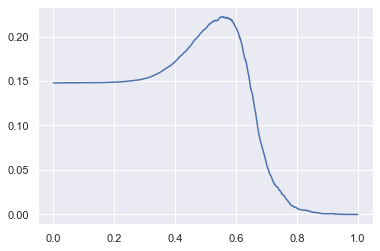

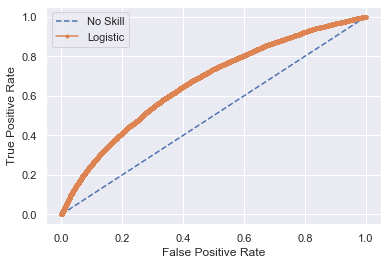

In [501]:
metrics_logit(X3, y3)

Results are better, however, want to select particular features that might help with performance

**Model with selected features using previous feature importance**

In [504]:
X4 = df_merged_all[['amt_income_total', 'amt_credit',
       'amt_annuity', 'name_type_suite', 'name_income_type',
       'name_family_status', 
       'flag_emp_phone',
       'flag_work_phone', 'flag_cont_mobile', 'flag_phone',
       'cnt_fam_members', 'ext_source_1', 'ext_source_2',
       'amt_req_credit_bureau_day',
       'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years',
       'bureau_avg_amt_credit',
       'bureau_credit_type', 'cc_cnt_prev']]

y4 = df_merged_all['target']

In [505]:
X4.fillna(0, inplace=True)

/Users/Daria/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Logistic Regression Model best F1 score 0.178 at prob decision threshold >= 0.489
Logistic Regression Model AUC score 0.595


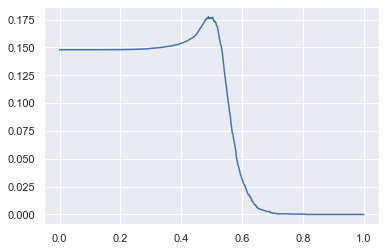

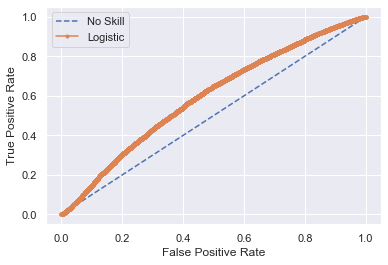

In [506]:
metrics_logit(X4, y4)

Selected features didn't work as expected --> continue with model feature 2

In [636]:
X5 = df_merged_all[['flag_own_realty', 'flag_own_car', 'name_income_type','name_family_status', 
                    'name_housing_type','region_population_relative','days_id_publish','flag_mobil', 
                    'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile','occupation_type',
                    'ext_source_1', 'ext_source_2','ext_source_3',
                    'days_last_phone_change', 
                    'amt_req_credit_bureau_day','name_contract_type', 'name_education_type', #'days_id_publish', 
                    'DTI_ratio', 'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years',
                    'bureau_avg_days_overdue', 'bureau_avg_cnt_prolong',
                    'bureau_max_pastdue_30_120', 'pos_avg_dpd', 'cc_cnt_prev',
                    'prev_app_reject_ratio', 'loan_cnt_loan', 'loan_avr_instalment',
                    'loan_dpd']]

y5 = df_merged_all['target']

In [637]:
X5.fillna(0, inplace=True)

/Users/Daria/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Logistic Regression Model best F1 score 0.270 at prob decision threshold >= 0.633
Logistic Regression Model AUC score 0.726


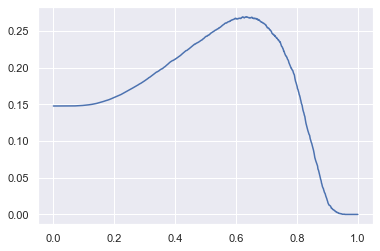

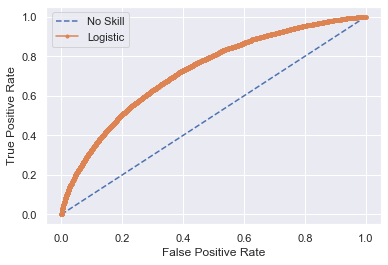

In [638]:
metrics_logit(X5, y5)

In [1150]:
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X5), y5, \
                                                            test_size=0.3, random_state=42)
#solve for imbalanced data
lr = LogisticRegression(class_weight='balanced', solver='liblinear') 
lr.fit(X_train, y_train)

y_pred_prob = lr.predict_proba(X_test)[:,1]
thresh_p = np.linspace(0,1,1000)

f1_scores = []
for p in thresh_p:
    model_val_labels = y_pred_prob >= p
    f1_scores.append(f1_score(y_test, model_val_labels))

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_p[np.argmax(f1_scores)]

AUC_score = roc_auc_score(y_test, y_pred_prob)

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))
print('Logistic Regression Model AUC score %.3f' 
      % (AUC_score))

Logistic Regression Model best F1 score 0.270 at prob decision threshold >= 0.633
Logistic Regression Model AUC score 0.726


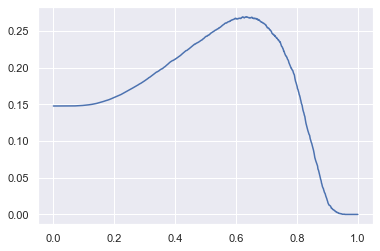

In [1151]:
plt.plot(thresh_p, f1_scores);
plt.show()

In [1099]:
y_pred_prob_lr = y_pred_prob
y_test_lr = y_test

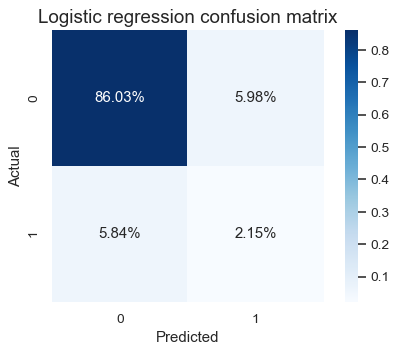

In [1096]:
lr_confusion = confusion_matrix(y_test, (y_pred_proba_rf >=best_thresh_p))
plt.figure(dpi=90)
sns.heatmap(lr_confusion/np.sum(lr_confusion), cmap=plt.cm.Blues, annot=True, square=True, fmt='.2%')


plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic regression confusion matrix', fontsize=15);

In [1247]:
lr_confusion

array([[79366,  5517],
       [ 5383,  1983]])

In [1248]:
1983/(1983+5383)

0.2692098832473527

### Random forest

In [667]:
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X5), y5, \
                                                            test_size=0.3, random_state=42)

In [668]:
n_estimators = [100, 500, 1000]
max_depth = [5,10]

for n in n_estimators:
    for depth in max_depth:
        rf = RandomForestClassifier(n_estimators=n, class_weight='balanced', max_depth=depth, n_jobs=1)
        rf.fit(X_train, y_train)
        y_pred_proba = rf.predict_proba(X_test)[:,1]
        AUC = roc_auc_score(y_test, y_pred_proba)
        print('n_estimators: {} Max_depth: {} AUC: {}'.format(n, depth, AUC))

n_estimators: 100 Max_depth: 5 AUC: 0.7264291108418072
n_estimators: 100 Max_depth: 10 AUC: 0.7361600484343994
n_estimators: 500 Max_depth: 5 AUC: 0.7261405726159509
n_estimators: 500 Max_depth: 10 AUC: 0.7375523819599199
n_estimators: 1000 Max_depth: 5 AUC: 0.7267308982066318
n_estimators: 1000 Max_depth: 10 AUC: 0.737683030881219


In [671]:
rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', max_depth=10, n_jobs=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [672]:
y_pred_proba = rf.predict_proba(X_test)[:,1]

In [673]:
AUC = roc_auc_score(y_test, y_pred_proba)

In [674]:
AUC

0.7376340071477985

In [1107]:
### Checking Random Rorest on an absurd value instead of 0, if its NULL
X00 = df_merged_all[['flag_own_realty', 'flag_own_car', 'name_income_type','name_family_status', 
                    'name_housing_type','region_population_relative','days_id_publish','flag_mobil', 
                    'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile','occupation_type',
                    'ext_source_1', 'ext_source_2','ext_source_3',
                    'days_last_phone_change', 
                    'amt_req_credit_bureau_day','name_contract_type', 'name_education_type', #'days_id_publish', 
                    'DTI_ratio', 'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years',
                    'bureau_avg_days_overdue', 'bureau_avg_cnt_prolong',
                    'bureau_max_pastdue_30_120', 'pos_avg_dpd', 'cc_cnt_prev',
                    'prev_app_reject_ratio', 'loan_cnt_loan', 'loan_avr_instalment',
                    'loan_dpd']]

y00 = df_merged_all['target']

In [1108]:
X00.fillna(-9999, inplace=True)

/Users/Daria/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [1109]:
X0_train, X0_test, y0_train, y0_test = train_test_split(pd.get_dummies(X00), y00, \
                                                            test_size=0.3, random_state=42)

In [1110]:
rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', max_depth=10, n_jobs=1)
rf.fit(X0_train, y0_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [1134]:
y_pred_proba_rf = rf.predict_proba(X0_test)[:,1]

In [1112]:
AUC_rf = roc_auc_score(y0_test, y_pred_proba_rf)

In [1113]:
##Performance got sightly better
AUC_rf

0.7377712022697009

In [1125]:
thresh_p = np.linspace(0,1,1000)
f1_scores_rf = []
y_pred_proba_rf = rf.predict_proba(X0_test)[:,1]    

for p in thresh_p:
    model_val_labels = y_pred_proba_rf >= p
    f1_scores_rf.append(f1_score(y0_test, model_val_labels))



In [1126]:
best_f1_score_rf = np.max(f1_scores_rf) 
best_thresh_p = thresh_p[np.argmax(f1_scores_rf)]

In [1127]:
best_f1_score_rf, best_thresh_p

(0.2866265965439519, 0.5785785785785785)

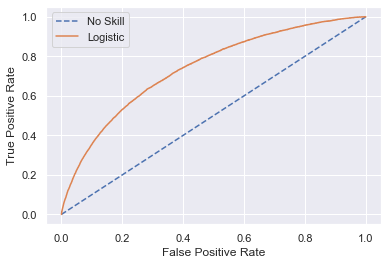

In [1135]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y0_test, y_pred_proba_rf)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_rf, tpr_rf, label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

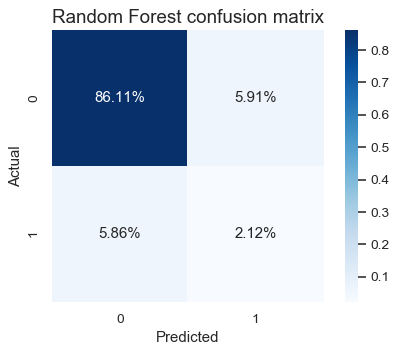

In [1086]:
rf_confusion = confusion_matrix(y_test, (y_pred_proba_rf >=best_thresh_p))
plt.figure(dpi=90)
sns.heatmap(rf_confusion/np.sum(rf_confusion), cmap=plt.cm.Blues, annot=True, square=True, fmt='.2%')


plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest confusion matrix', fontsize=15);

In [1079]:
rf_confusion

array([[79435,  5448],
       [ 5410,  1956]])

In [1246]:
1956/(1956+5410)

0.26554439315775186

## XGBoost

In [595]:
import xgboost as xgb

In [1146]:
X6 = df_merged_all[['flag_own_realty', 'flag_own_car', 'name_income_type','name_family_status', 
                    'name_housing_type','region_population_relative','flag_mobil', 
                    'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile','occupation_type',
                    'ext_source_1', 'ext_source_2','ext_source_3',
                    'days_last_phone_change', 
                    'amt_req_credit_bureau_day','name_contract_type', 'name_education_type', 'days_id_publish', 
                    'DTI_ratio', 'AGE_years', 'DAYS_EMPLOYED_years', 'LOAN_TERM_years',
                    'bureau_avg_days_overdue', 'bureau_avg_cnt_prolong',
                    'bureau_max_pastdue_30_120', 'pos_avg_dpd', 'cc_cnt_prev',
                    'prev_app_reject_ratio', 'loan_cnt_loan', 'loan_avr_instalment',
                    'loan_dpd']]

y6 = df_merged_all['target']

In [630]:
#duplicate_columns = X6.columns[X6.columns.duplicated()]

In [631]:
#duplicate_columns

Index([], dtype='object')

In [1147]:
y6.value_counts()

0    282672
1     24824
Name: target, dtype: int64

In [791]:
282672/24824

11.38704479535933

In [1148]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X6), y6, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [1149]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=7,
                        objective='binary:logistic', #new objective
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=12,
                        n_jobs=1,
                        colsample_bytree=.7,
                        scale_pos_weight=5 #best so far
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', 
                    early_stopping_rounds=20,
                    verbose=True)

[0]	validation_0-auc:0.73535	validation_1-auc:0.71359
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.75340	validation_1-auc:0.72353
[2]	validation_0-auc:0.76381	validation_1-auc:0.72895
[3]	validation_0-auc:0.77253	validation_1-auc:0.73274
[4]	validation_0-auc:0.77968	validation_1-auc:0.73782
[5]	validation_0-auc:0.78431	validation_1-auc:0.73795
[6]	validation_0-auc:0.78918	validation_1-auc:0.73997
[7]	validation_0-auc:0.79533	validation_1-auc:0.74136
[8]	validation_0-auc:0.79953	validation_1-auc:0.74173
[9]	validation_0-auc:0.80202	validation_1-auc:0.74271
[10]	validation_0-auc:0.80481	validation_1-auc:0.74290
[11]	validation_0-auc:0.80756	validation_1-auc:0.74245
[12]	validation_0-auc:0.80877	validation_1-auc:0.74312
[13]	validation_0-auc:0.81088	validation_1-auc:0.74431
[14]	validation_0-auc:0.81373	validation_1-auc:0.74344
[15]	validation_0-auc:0.8147

In [665]:
roc_auc_score(y_val, gbm.predict_proba(X_val, ntree_limit=gbm.best_ntree_limit)[:,1]) 

0.7443154236149433

## Model comparison (ROC curve)

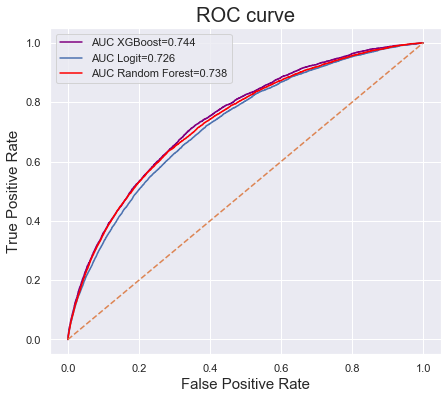

In [1142]:
fpr, tpr, thresholds = roc_curve(y_val, gbm.predict_proba(X_val, ntree_limit=gbm.best_ntree_limit)[:,1])

fpr_l, tpr_l, thresholds_lr = roc_curve(y_test_lr, y_pred_prob_lr)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y0_test, y_pred_proba_rf)

auc1 = roc_auc_score(y_val,gbm.predict_proba(X_val, ntree_limit=gbm.best_ntree_limit)[:,1])
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='purple')
plt.plot(fpr_l, tpr_l)
plt.plot(fpr_rf, tpr_rf, color='red')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.grid(color='white')
plt.legend(["AUC XGBoost=%.3f"%auc, "AUC Logit=%.3f"%AUC_score, "AUC Random Forest=%.3f"%AUC_rf])
plt.show()

Performance of all three models are pretty much the same with slightly better performance with XGBoost model

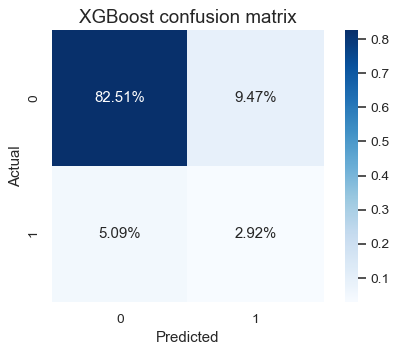

In [1094]:
gbm_confusion = confusion_matrix(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit))
plt.figure(dpi=90)
sns.heatmap(gbm_confusion/np.sum(gbm_confusion), cmap=plt.cm.Blues, annot=True, square=True, fmt='.2%')


plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost confusion matrix', fontsize=15);

In [1244]:
gbm_confusion

array([[50744,  5826],
       [ 3131,  1798]])

In [1245]:
1798/(1798+3131)

0.36477987421383645

In [1093]:
f1_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit))

0.286465386760137

In [1092]:
gbm_confusion

array([[50744,  5826],
       [ 3131,  1798]])

In [ ]:
## XGBoost model works best with:
# f1 score = 0.286
# AUC = 0.744